 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [61]:
!pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from tqdm import notebook

Скачаем обучающую и контрольную выборки.

In [62]:
transform = transforms.Compose(
    [transforms.ToTensor()])


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [63]:
trainset.data.shape

torch.Size([60000, 28, 28])

In [64]:
testset.data.shape

torch.Size([10000, 28, 28])

In [65]:
pd_trainset = pd.DataFrame(trainset.targets.numpy())

for i in range(10):
  print('Class ', i, ': ', (pd_trainset == i).sum())

Class  0 :  0    6000
dtype: int64
Class  1 :  0    6000
dtype: int64
Class  2 :  0    6000
dtype: int64
Class  3 :  0    6000
dtype: int64
Class  4 :  0    6000
dtype: int64
Class  5 :  0    6000
dtype: int64
Class  6 :  0    6000
dtype: int64
Class  7 :  0    6000
dtype: int64
Class  8 :  0    6000
dtype: int64
Class  9 :  0    6000
dtype: int64


In [66]:
pd_testset = pd.DataFrame(testset.targets.numpy())
for i in range(10):
  print('Class ', i, ': ', (pd_testset == i).sum())

Class  0 :  0    1000
dtype: int64
Class  1 :  0    1000
dtype: int64
Class  2 :  0    1000
dtype: int64
Class  3 :  0    1000
dtype: int64
Class  4 :  0    1000
dtype: int64
Class  5 :  0    1000
dtype: int64
Class  6 :  0    1000
dtype: int64
Class  7 :  0    1000
dtype: int64
Class  8 :  0    1000
dtype: int64
Class  9 :  0    1000
dtype: int64


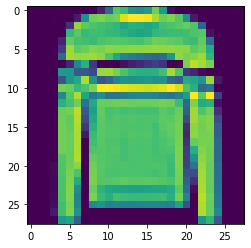

In [67]:
plt.imshow(trainset.data[5])

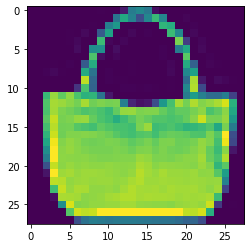

In [68]:
plt.imshow(trainset.data[100])

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [70]:
MLP = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),  
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10)
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-3
optimizer = torch.optim.SGD(MLP.parameters(), lr=learning_rate)
MLP.to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=10, bias=True)
)

In [71]:
loss_history = []

for epoch in notebook.tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # getting curr batch
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # initial weights
        optimizer.zero_grad()

        # forward && backward && optimize
        y_pred = MLP(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # accumulated loss
        running_loss += loss.item()
        
        if i % 2000 == 1999: # printing loss every 2000th batch
            loss_history.append(running_loss / 2000)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 9.180
[1,  4000] loss: 7.763
[1,  6000] loss: 4.710
[1,  8000] loss: 3.983
[1, 10000] loss: 3.492
[1, 12000] loss: 3.065
[1, 14000] loss: 2.848


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 2.614
[2,  4000] loss: 2.435
[2,  6000] loss: 2.317
[2,  8000] loss: 2.252
[2, 10000] loss: 2.221
[2, 12000] loss: 2.215
[2, 14000] loss: 2.029


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 1.948
[3,  4000] loss: 1.888
[3,  6000] loss: 1.905
[3,  8000] loss: 1.808
[3, 10000] loss: 1.838
[3, 12000] loss: 1.852
[3, 14000] loss: 1.815


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 1.739
[4,  4000] loss: 1.743
[4,  6000] loss: 1.677
[4,  8000] loss: 1.696
[4, 10000] loss: 1.694
[4, 12000] loss: 1.627
[4, 14000] loss: 1.626


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 1.554
[5,  4000] loss: 1.596
[5,  6000] loss: 1.561
[5,  8000] loss: 1.608
[5, 10000] loss: 1.574
[5, 12000] loss: 1.612
[5, 14000] loss: 1.560


  0%|          | 0/15000 [00:00<?, ?it/s]

[6,  2000] loss: 1.473
[6,  4000] loss: 1.536
[6,  6000] loss: 1.518
[6,  8000] loss: 1.511
[6, 10000] loss: 1.438
[6, 12000] loss: 1.510
[6, 14000] loss: 1.508


  0%|          | 0/15000 [00:00<?, ?it/s]

[7,  2000] loss: 1.484
[7,  4000] loss: 1.387
[7,  6000] loss: 1.396
[7,  8000] loss: 1.481
[7, 10000] loss: 1.468
[7, 12000] loss: 1.454
[7, 14000] loss: 1.410


  0%|          | 0/15000 [00:00<?, ?it/s]

[8,  2000] loss: 1.403
[8,  4000] loss: 1.428
[8,  6000] loss: 1.373
[8,  8000] loss: 1.337
[8, 10000] loss: 1.436
[8, 12000] loss: 1.401
[8, 14000] loss: 1.380


  0%|          | 0/15000 [00:00<?, ?it/s]

[9,  2000] loss: 1.360
[9,  4000] loss: 1.394
[9,  6000] loss: 1.351
[9,  8000] loss: 1.359
[9, 10000] loss: 1.340
[9, 12000] loss: 1.276
[9, 14000] loss: 1.347


  0%|          | 0/15000 [00:00<?, ?it/s]

[10,  2000] loss: 1.324
[10,  4000] loss: 1.255
[10,  6000] loss: 1.308
[10,  8000] loss: 1.326
[10, 10000] loss: 1.307
[10, 12000] loss: 1.305
[10, 14000] loss: 1.351


In [72]:
correct = list(0. for i in range(10))
total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        y_pred = MLP(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            correct[label] += c[i].item()
            total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct[i] / total[i]))
    
print('\n General acccuracy: ', (sum(correct) / sum(total)) * 100, '%')

Accuracy of T-shirt/top : 84 %
Accuracy of Trouser : 96 %
Accuracy of Pullover : 84 %
Accuracy of Dress : 92 %
Accuracy of  Coat : 66 %
Accuracy of Sandal : 92 %
Accuracy of Shirt : 54 %
Accuracy of Sneaker : 96 %
Accuracy of   Bag : 95 %
Accuracy of Ankle boot : 94 %

 General acccuracy:  85.7 %


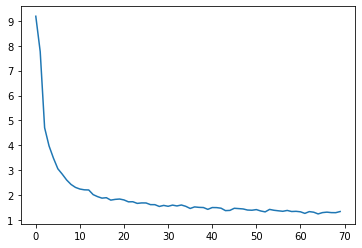

In [73]:
plt.plot(loss_history, label='loss')

In [74]:
class Conv(nn.Module):
    def __init__(self):
      
        super(Conv, self).__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        
        self.fc1 = nn.Linear(2 * 2 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.conv3(F.relu(self.conv2(x))))
#        print(x.shape)
        x = x.view(-1, 2 * 2 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [75]:
# initializing Conv
conv = Conv()
conv.to(device)

# choosing loss function
loss_fn = torch.nn.CrossEntropyLoss()

# choosing learning rate and optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(conv.parameters(), lr=learning_rate)

In [76]:
summary(conv, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
            Conv2d-4             [-1, 32, 4, 4]          12,832
         MaxPool2d-5             [-1, 32, 2, 2]               0
            Linear-6                  [-1, 120]          15,480
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 41,898
Trainable params: 41,898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.16
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [77]:
cnn_loss_history = []

for epoch in notebook.tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(notebook.tqdm(trainloader)):
        # getting curr batch
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # initial weights
        optimizer.zero_grad()

        # forward && backward && optimize
        y_pred = conv(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # accumulated loss
        running_loss += loss.item()


        
        if i % 2000 == 1999: # printing loss every 2000th batch
            cnn_loss_history.append(running_loss / 2000)

            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.284
[1,  4000] loss: 0.872
[1,  6000] loss: 0.788
[1,  8000] loss: 0.724
[1, 10000] loss: 0.680
[1, 12000] loss: 0.661
[1, 14000] loss: 0.640


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.599
[2,  4000] loss: 0.584
[2,  6000] loss: 0.551
[2,  8000] loss: 0.547
[2, 10000] loss: 0.534
[2, 12000] loss: 0.535
[2, 14000] loss: 0.497


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.502
[3,  4000] loss: 0.475
[3,  6000] loss: 0.474
[3,  8000] loss: 0.465
[3, 10000] loss: 0.458
[3, 12000] loss: 0.459
[3, 14000] loss: 0.440


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 0.433
[4,  4000] loss: 0.430
[4,  6000] loss: 0.418
[4,  8000] loss: 0.410
[4, 10000] loss: 0.414
[4, 12000] loss: 0.398
[4, 14000] loss: 0.396


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 0.391
[5,  4000] loss: 0.387
[5,  6000] loss: 0.385
[5,  8000] loss: 0.391
[5, 10000] loss: 0.366
[5, 12000] loss: 0.358
[5, 14000] loss: 0.360


  0%|          | 0/15000 [00:00<?, ?it/s]

[6,  2000] loss: 0.334
[6,  4000] loss: 0.355
[6,  6000] loss: 0.366
[6,  8000] loss: 0.336
[6, 10000] loss: 0.354
[6, 12000] loss: 0.357
[6, 14000] loss: 0.353


  0%|          | 0/15000 [00:00<?, ?it/s]

[7,  2000] loss: 0.321
[7,  4000] loss: 0.342
[7,  6000] loss: 0.334
[7,  8000] loss: 0.321
[7, 10000] loss: 0.336
[7, 12000] loss: 0.314
[7, 14000] loss: 0.335


  0%|          | 0/15000 [00:00<?, ?it/s]

[8,  2000] loss: 0.310
[8,  4000] loss: 0.318
[8,  6000] loss: 0.315
[8,  8000] loss: 0.316
[8, 10000] loss: 0.314
[8, 12000] loss: 0.314
[8, 14000] loss: 0.312


  0%|          | 0/15000 [00:00<?, ?it/s]

[9,  2000] loss: 0.312
[9,  4000] loss: 0.299
[9,  6000] loss: 0.308
[9,  8000] loss: 0.305
[9, 10000] loss: 0.301
[9, 12000] loss: 0.297
[9, 14000] loss: 0.284


  0%|          | 0/15000 [00:00<?, ?it/s]

[10,  2000] loss: 0.302
[10,  4000] loss: 0.300
[10,  6000] loss: 0.293
[10,  8000] loss: 0.279
[10, 10000] loss: 0.277
[10, 12000] loss: 0.278
[10, 14000] loss: 0.288


In [78]:
correct = list(0. for i in range(10))
total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        y_pred = conv(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            correct[label] += c[i].item()
            total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * correct[i] / total[i]))
    
print('\nGeneral Acccuracy: ', (sum(correct) / sum(total)) * 100, '%')

Accuracy of T-shirt/top : 79 %
Accuracy of Trouser : 96 %
Accuracy of Pullover : 82 %
Accuracy of Dress : 91 %
Accuracy of  Coat : 85 %
Accuracy of Sandal : 95 %
Accuracy of Shirt : 67 %
Accuracy of Sneaker : 95 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 94 %

General Acccuracy:  88.59 %


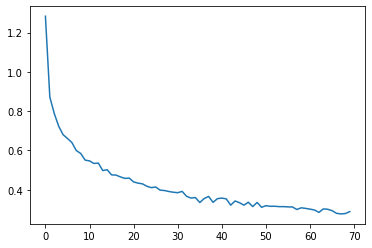

In [79]:
plt.plot(cnn_loss_history, label='loss')